In [1]:
import nltk
from nltk.corpus import brown, stopwords
from collections import Counter
import pyinflect
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

nltk.download("brown")
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\lauri\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lauri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lauri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Combine files in ICE Nigeria to one in order to make things easier in future steps
if not os.path.exists("./ice_nig_combined.txt"):
    PATH = ".\\ice-nig\\txt - without speaker tags\\"
    files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(PATH) for f in filenames if os.path.splitext(f)[1] == '.txt']
    combined = ""
    for file in files:
        with open(file, "r", encoding="utf-8") as f:
            for line in f.readlines():
                combined += line
    with open("./ice_nig_combined.txt", "w", encoding="utf-8") as f:
        f.write(combined)
        

Infflections: ['hate', 'hates', 'hate', 'hate', 'hated', 'hated', 'hating', 'hates'] ['love', 'loves', 'love', 'love', 'loved', 'loved', 'loving', 'loves']
Occurances in brown: {'hate': 42, 'hates': 4, 'hated': 28, 'hating': 2} {'love': 214, 'loves': 19, 'loved': 56, 'loving': 14}
{'hate': 31, 'hates': 2, 'hated': 3, 'hating': 0}
Occurances in ice-nig: {'hate': 31, 'hates': 2, 'hated': 3, 'hating': 0} {'love': 256, 'loves': 11, 'loved': 32, 'loving': 15}


<BarContainer object of 4 artists>

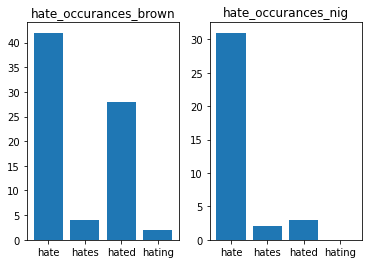

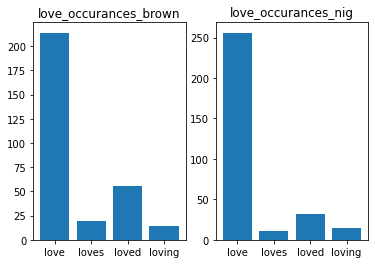

In [3]:
#1

hate_inflections = pyinflect.getAllInflections("hate")
love_inflections = pyinflect.getAllInflections("love")
hate_inflections_words = [x[0] for x in hate_inflections.values()]
love_inflections_words = [x[0] for x in love_inflections.values()]
print("Inflections:", hate_inflections_words, love_inflections_words)

with open("./ice_nig_combined.txt", "r", encoding="utf-8") as f:
    nig_ice_words = nltk.word_tokenize(f.read())

hate_occurances_brown, love_occurances_brown, hate_occurances_nig, love_occurances_nig = {}, {}, {}, {}
wordcounts_brown = Counter(brown.words())
wordcounts_nig = Counter(nig_ice_words)
for word in hate_inflections_words:
    hate_occurances_brown[word] = wordcounts_brown[word]
    hate_occurances_nig[word] = wordcounts_nig[word]
for word in love_inflections_words:
    love_occurances_brown[word] = wordcounts_brown[word]
    love_occurances_nig[word] = wordcounts_nig[word]
print("Occurances in brown:", hate_occurances_brown, love_occurances_brown)
print(hate_occurances_nig)
print("Occurances in ice-nig:", hate_occurances_nig, love_occurances_nig)


fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('hate_occurances_brown')
ax1.bar(hate_occurances_brown.keys(), hate_occurances_brown.values())
ax2.title.set_text('hate_occurances_nig')
plt.bar(hate_occurances_nig.keys(), hate_occurances_nig.values())

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('love_occurances_brown')
ax1.bar(love_occurances_brown.keys(), love_occurances_brown.values())
ax2.title.set_text('love_occurances_nig')
plt.bar(love_occurances_nig.keys(), love_occurances_nig.values())

In [4]:
#2 (this is probably very wrong)

stop_words = set(stopwords.words('english'))
brown_filtered = [w for w in brown.words() if not w.lower() in stop_words]
ice_nig_filtered = [w for w in nig_ice_words if not w.lower() in stop_words]

words_to_look_for = hate_inflections_words + love_inflections_words

co_occurring_words_brown = []
for word in words_to_look_for:
    for ngram in nltk.ngrams(brown_filtered, 1):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_brown.append(ngram[i])
    for ngram in nltk.ngrams(brown_filtered, 2):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_brown.append(ngram[i])    
    for ngram in nltk.ngrams(brown_filtered, 3):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_brown.append(ngram[i])

co_occurring_words_icenig = []
for word in words_to_look_for:
    for ngram in nltk.ngrams(ice_nig_filtered, 1):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_icenig.append(ngram[i])
    for ngram in nltk.ngrams(ice_nig_filtered, 2):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_icenig.append(ngram[i])    
    for ngram in nltk.ngrams(ice_nig_filtered, 3):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_icenig.append(ngram[i])
    


wordcounts_brown = Counter(co_occurring_words_brown)
wordcounts_icenig = Counter(co_occurring_words_icenig)
print("top50 wordcounts_brown:", wordcounts_brown.most_common(50), "\n")
print("top50 wordcounts_icenig:", wordcounts_icenig.most_common(50), "\n")

top50 wordcounts_brown: [(',', 995), ('.', 854), ('``', 180), ("''", 143), ('God', 91), ('--', 58), ('man', 57), (';', 57), ('us', 47), ('way', 44), ('country', 42), ('one', 40), ('much', 40), ('know', 39), ('world', 36), ('true', 36), ('even', 35), ('mother', 35), ('could', 33), ('faith', 33), ('?', 33), ("I'd", 30), ('give', 30), ('woman', 29), ('must', 29), ('life', 29), ('lost', 29), ('another', 27), ('little', 27), ('fell', 27), ('fallen', 27), ('!', 27), ('girl', 27), ('Johnnie', 27), (':', 25), ('never', 25), ('made', 24), ('love', 21), ('alive', 21), ('well', 21), ("mother's", 21), ('brethren', 21), ('knowledge', 21), ('nature', 21), ('beautiful', 21), ('hate', 21), ('(', 20), ('people', 20), ('cause', 18), ('think', 18)] 

top50 wordcounts_icenig: [('.', 531), (',', 269), ('know', 136), ('people', 99), ('would', 99), ('show', 94), ("'s", 81), ('erm', 75), ('God', 72), ('reading', 66), ('``', 65), ("''", 65), ('children', 63), ('affection', 62), ('yeah', 59), ('like', 57), ('mu

In [5]:
#3

#Extract sentences from ice_nig to same format they are in brown.sents()
ice_nig_sents = []
with open("./ice_nig_combined.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        temp = []
        for word in line.split(" "): 
            temp.append(word.strip("\n"))
        ice_nig_sents.append(temp)
    #print(ice_nig_sents[:20])


most_common_cowords_brown = [x[0] for x in wordcounts_brown.most_common(50)]
most_common_cowords_icenig = [x[0] for x in wordcounts_icenig.most_common(50)]
brown_sentences_hate = []
brown_sentences_love = []
i = 0
for word1 in most_common_cowords_brown:
    print(1, i, 50)
    i += 1
    for word2 in hate_inflections_words:
        for sent in brown.sents():
            for sent_ngram in nltk.ngrams(sent, 3): #3-grams should also include all 1s and 2s
                if word1 in sent_ngram and word2 in sent_ngram:
                    if sent not in brown_sentences_hate:
                        brown_sentences_hate.append(sent)
print("1 done")
i = 0
for word1 in most_common_cowords_brown:
    print(2, i, 50)
    i += 1
    for word2 in love_inflections_words:
        for sent in brown.sents():
            for sent_ngram in nltk.ngrams(sent, 3): #3-grams should also include all 1s and 2s
                if word1 in sent_ngram and word2 in sent_ngram:
                    if sent not in brown_sentences_love:
                        brown_sentences_love.append(sent)
print(len(brown_sentences_hate))
print(len(brown_sentences_love))

icenig_sentences_hate = []
icenig_sentences_love = []
i = 0
for word1 in most_common_cowords_icenig:
    print(1, i, 50)
    i += 1
    for word2 in hate_inflections_words:
        for sent in ice_nig_sents:
            for sent_ngram in nltk.ngrams(sent, 3): #3-grams should also include all 1s and 2s
                if word1 in sent_ngram and word2 in sent_ngram:
                    if sent not in icenig_sentences_hate:
                        icenig_sentences_hate.append(sent)
i = 0
for word1 in most_common_cowords_icenig:
    print(2, i, 50)
    i += 1
    for word2 in love_inflections_words:
        for sent in ice_nig_sents:
            for sent_ngram in nltk.ngrams(sent, 3): #3-grams should also include all 1s and 2s
                if word1 in sent_ngram and word2 in sent_ngram:
                    if sent not in icenig_sentences_love:
                        icenig_sentences_love.append(sent)
print(len(icenig_sentences_hate))
print(len(icenig_sentences_love))

with open("./brown_sentences_hate.txt", "w", encoding="utf-8") as f:
    for item in brown_sentences_hate:
        f.write(" ".join(item) + "\n")
with open("./brown_sentences_love.txt", "w", encoding="utf-8") as f:
    for item in brown_sentences_love:
        f.write(" ".join(item) + "\n")
with open("./icenig_sentences_hate.txt", "w", encoding="utf-8") as f:
    for item in icenig_sentences_hate:
        f.write(" ".join(item) + "\n")
with open("./icenig_sentences_love.txt", "w", encoding="utf-8") as f:
    for item in icenig_sentences_love:
        f.write(" ".join(item) + "\n")

1 0 50
1 1 50
1 2 50
1 3 50
1 4 50
1 5 50
1 6 50
1 7 50
1 8 50
1 9 50
1 10 50
1 11 50
1 12 50
1 13 50
1 14 50
1 15 50
1 16 50
1 17 50
1 18 50
1 19 50
1 20 50
1 21 50
1 22 50
1 23 50
1 24 50
1 25 50
1 26 50
1 27 50
1 28 50
1 29 50
1 30 50
1 31 50
1 32 50
1 33 50
1 34 50
1 35 50
1 36 50
1 37 50
1 38 50
1 39 50
1 40 50
1 41 50
1 42 50
1 43 50
1 44 50
1 45 50
1 46 50
1 47 50
1 48 50
1 49 50
1 done
2 0 50
2 1 50
2 2 50
2 3 50
2 4 50
2 5 50
2 6 50
2 7 50
2 8 50
2 9 50
2 10 50
2 11 50
2 12 50
2 13 50
2 14 50
2 15 50
2 16 50
2 17 50
2 18 50
2 19 50
2 20 50
2 21 50
2 22 50
2 23 50
2 24 50
2 25 50
2 26 50
2 27 50
2 28 50
2 29 50
2 30 50
2 31 50
2 32 50
2 33 50
2 34 50
2 35 50
2 36 50
2 37 50
2 38 50
2 39 50
2 40 50
2 41 50
2 42 50
2 43 50
2 44 50
2 45 50
2 46 50
2 47 50
2 48 50
2 49 50
54
256
1 0 50
1 1 50
1 2 50
1 3 50
1 4 50
1 5 50
1 6 50
1 7 50
1 8 50
1 9 50
1 10 50
1 11 50
1 12 50
1 13 50
1 14 50
1 15 50
1 16 50
1 17 50
1 18 50
1 19 50
1 20 50
1 21 50
1 22 50
1 23 50
1 24 50
1 25 50
1 26 50


In [6]:
#4 TODO